# Lab 5: Spam Detection

**Deadline**: June 18th, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/file/d/1vDnjUn0OESVJuJyYXkYvqRSQnodb9hgY/view?usp=sharing

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import time
import matplotlib.pyplot as plt

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd gdrive/MyDrive/EngSci 2T1 + PEY/Year 4/Summer/APS360/Labs/Lab_5_Spam_Detection

/content/gdrive/MyDrive/EngSci 2T1 + PEY/Year 4/Summer/APS360/Labs/Lab_5_Spam_Detection


In [ ]:
for line in open('SMSSpamCollection'):
    if line[0] == 's':
        print(line)
        break

for line in open('SMSSpamCollection'):
    if line[0] == 'h':
        print(line)
        break

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...



**Answer:**

As shown in the print outs above, the label for a spam message is "spam" and the label for a non-spam message is "ham". 

### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
spam = 0
ham = 0
for line in open('SMSSpamCollection'):
    if line[0] == 's':
        spam += 1
    elif line[0] == 'h':
        ham += 1

print("There are", spam, "spam messages in the data set.")
print("There are", ham, "non-spam messages in the data set.")

There are 747 spam messages in the data set.
There are 4827 non-spam messages in the data set.


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

**Answer:**

Advantages:


1.   Requires less memory and has faster inference due to a much smaller vocabulary (less than 100 characters vs millions of words)
2.   Able to recognize and interpret misspelled words/typos

Disadvantages:


1.   Higher computational cost
2.   May result in a lower accuracy compared to word level RNN





### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [ ]:
import torchtext

text_field = torchtext.legacy.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.legacy.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.legacy.data.TabularDataset("SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)

In [ ]:
dataset[0].sms

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [ ]:
dataset[0].label

0

In [ ]:
np.random.seed(50)
train, valid, test = dataset.split(split_ratio=[0.6,0.2,0.2], 
                                   stratified=True, 
                                   strata_field='label')

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [ ]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

**Answer:**

It is important to have a balanced training set because it is undesirable to introduce any biases into the neural network model. In this case, since there are many more non-spam messages, the model will be biased towards the non-spam class. As a result, even if the model results in a high training accuracy, it does not indicate that we have learned a good model for this problem. 

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [ ]:
text_field.build_vocab(train)

In [ ]:
text_field.vocab.stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f491b47c350>>,
            {'\t': 106,
             '\n': 107,
             ' ': 2,
             '!': 44,
             '"': 80,
             '#': 79,
             '$': 90,
             '%': 93,
             '&': 63,
             "'": 60,
             '(': 76,
             ')': 72,
             '*': 71,
             '+': 75,
             ',': 46,
             '-': 64,
             '.': 16,
             '/': 59,
             '0': 14,
             '1': 23,
             '2': 25,
             '3': 42,
             '4': 37,
             '5': 32,
             '6': 43,
             '7': 40,
             '8': 28,
             '9': 49,
             ':': 65,
             ';': 74,
             '<': 87,
             '<pad>': 1,
             '<unk>': 0,
             '=': 82,
             '>': 81,
             '?': 61,
             '@': 83,
             'A': 41,
             'B': 55,
             'C': 34,

In [ ]:
text_field.vocab.itos

['<unk>',
 '<pad>',
 ' ',
 'e',
 'o',
 't',
 'a',
 'n',
 'r',
 'i',
 's',
 'l',
 'u',
 'h',
 '0',
 'd',
 '.',
 'c',
 'm',
 'y',
 'w',
 'p',
 'g',
 '1',
 'f',
 '2',
 'b',
 'T',
 '8',
 'k',
 'E',
 'v',
 '5',
 'S',
 'C',
 'O',
 'I',
 '4',
 'N',
 'x',
 '7',
 'A',
 '3',
 '6',
 '!',
 'R',
 ',',
 'P',
 'W',
 '9',
 'U',
 'M',
 'L',
 'H',
 'D',
 'B',
 'Y',
 'F',
 'G',
 '/',
 "'",
 '?',
 '£',
 '&',
 '-',
 ':',
 'X',
 'z',
 'V',
 'j',
 'K',
 '*',
 ')',
 'J',
 ';',
 '+',
 '(',
 'q',
 'Q',
 '#',
 '"',
 '>',
 '=',
 '@',
 'Z',
 'ü',
 'Ü',
 '<',
 '|',
 '\x92',
 '$',
 '[',
 ']',
 '%',
 '‘',
 '\x93',
 '¡',
 '“',
 '_',
 '’',
 '–',
 '…',
 '\\',
 '\x94',
 '\x96',
 'é',
 '\t',
 '\n',
 '~',
 '\x91',
 '^',
 '»',
 'É',
 'è',
 'ì',
 '—',
 '┾',
 '〨',
 '鈥']

**Answer:**

As shown in the code above, the variable `text_field.vocab.stoi` is a dictionary mapping of character tokens to integer indices, where `stoi` stands for string to integer. 

The variable `text_field.vocab.itos` represents a list mapping integer indices to the character tokens, where `itos` stands for integer to string. 

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

**Answer:**

The `<unk>` token represents an unknown token, which means that the token is unrecognized. 

The `<pad>` token represents padding. Since the SMS text messages vary in length, padding is applied to ensure training data in the same batch have equal lengths. 

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
i = 0
for batch in train_iter:
    if i == 10:
        break
    pad = 0
    print("Batch", i+1, ":")
    print("\tMaximum Length =", int(batch.sms[1][0]))
    for sms in batch.sms[1]:
        pad += batch.sms[1][0] - sms
    print("\tNumber of <pad> tokens =", int(pad))
    i += 1

Batch 1 :
	Maximum Length = 55
	Number of <pad> tokens = 33
Batch 2 :
	Maximum Length = 25
	Number of <pad> tokens = 25
Batch 3 :
	Maximum Length = 76
	Number of <pad> tokens = 35
Batch 4 :
	Maximum Length = 143
	Number of <pad> tokens = 0
Batch 5 :
	Maximum Length = 156
	Number of <pad> tokens = 0
Batch 6 :
	Maximum Length = 88
	Number of <pad> tokens = 56
Batch 7 :
	Maximum Length = 50
	Number of <pad> tokens = 18
Batch 8 :
	Maximum Length = 144
	Number of <pad> tokens = 1
Batch 9 :
	Maximum Length = 149
	Number of <pad> tokens = 32
Batch 10 :
	Maximum Length = 80
	Number of <pad> tokens = 55


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
class RNN(nn.Module):
    def __init__(self, hidden_size):
        super(RNN, self).__init__()
        self.name = "rnn"
        self.emb = torch.eye(len(text_field.vocab.itos))
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(len(text_field.vocab.itos), hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)
    
    def forward(self, x):
        x = self.emb[x]
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [ ]:
def get_accuracy(model, data_loader):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """             
    correct, total = 0, 0
    for batch in data_loader:
        messages = batch.sms
        labels = batch.label
        output = model(messages[0])
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [ ]:
def get_val_loss(model, valid_loader, criterion):
    total_val_loss = 0.0
    i = 0
    for batch in valid_loader:
        messages = batch.sms
        labels = batch.label
        pred = model(messages[0])
        loss = criterion(pred, labels)
        total_val_loss += loss.item()
        i += 1
    val_loss = float(total_val_loss)/(i + 1)
    return val_loss

In [ ]:
def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-5):
    torch.manual_seed(1000)          
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_acc, train_loss, val_acc, val_loss = [], [], [], []
    epochs = []

    start_time = time.time()
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        i = 0
        for batch in train_loader:
            messages = batch.sms
            labels = batch.label
            optimizer.zero_grad()
            pred = model(messages[0])
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            i += 1
        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        train_loss.append(float(total_train_loss)/(i + 1))
        val_acc.append(get_accuracy(model, valid_loader))
        val_loss.append(get_val_loss(model, valid_loader, criterion))
        print(("Epoch {}: Train acc: {}, Train loss: {} |"+
               "Validation acc: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_acc[-1],
                   train_loss[-1],
                   val_acc[-1],
                   val_loss[-1]))
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # Plotting
    plt.title("Train vs Validation Loss")
    plt.plot(epochs, train_loss, label="Train")
    plt.plot(epochs, val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train vs Validation Accuracy")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

Epoch 1: Train acc: 0.7141435914442049, Train loss: 0.6804776721879056 |Validation acc: 0.5210762331838565, Validation loss: 0.6698493676053153
Epoch 2: Train acc: 0.8942132316365445, Train loss: 0.4965032028524499 |Validation acc: 0.8834080717488789, Validation loss: 0.4002683055069711
Epoch 3: Train acc: 0.8885756922566739, Train loss: 0.3184615362631647 |Validation acc: 0.9542600896860987, Validation loss: 0.22565977896253267
Epoch 4: Train acc: 0.8623777151384513, Train loss: 0.4132004074360195 |Validation acc: 0.9515695067264573, Validation loss: 0.28194522733489674
Epoch 5: Train acc: 0.9149394793566573, Train loss: 0.28518127595123494 |Validation acc: 0.947085201793722, Validation loss: 0.18944910044471422
Epoch 6: Train acc: 0.8512684463604709, Train loss: 0.39714714010295116 |Validation acc: 0.8896860986547085, Validation loss: 0.4248014572593901
Epoch 7: Train acc: 0.9265461780799205, Train loss: 0.26450181503437065 |Validation acc: 0.9461883408071748, Validation loss: 0.1699

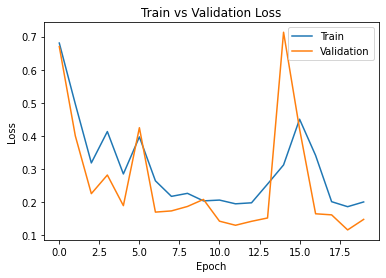

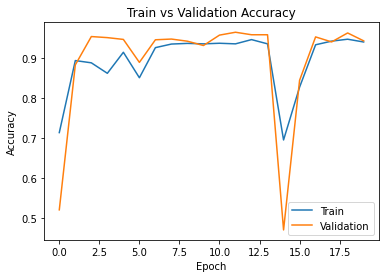

Final Training Accuracy: 0.9406400265295971
Final Validation Accuracy: 0.9434977578475336


In [ ]:
valid_iter = torchtext.legacy.data.BucketIterator(valid,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
model = RNN(50)
train(model, train_iter, valid_iter, num_epochs=20, learning_rate=2e-4)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

Epoch 1: Train acc: 0.5206433427292323, Train loss: 0.6903340483966627 |Validation acc: 0.13542600896860987, Validation loss: 0.7396099650197558
Epoch 2: Train acc: 0.7149726413530094, Train loss: 0.6690227590109172 |Validation acc: 0.525560538116592, Validation loss: 0.6657121595409181
Epoch 3: Train acc: 0.8792903332780634, Train loss: 0.5217389828280399 |Validation acc: 0.905829596412556, Validation loss: 0.37643614245785606
Epoch 4: Train acc: 0.8995191510528934, Train loss: 0.37207915084926707 |Validation acc: 0.9237668161434978, Validation loss: 0.3236350541313489
Epoch 5: Train acc: 0.8948764715635882, Train loss: 0.32155652532452034 |Validation acc: 0.9488789237668162, Validation loss: 0.2462928079896503
Epoch 6: Train acc: 0.9041618305421987, Train loss: 0.3088581658507648 |Validation acc: 0.9506726457399103, Validation loss: 0.2247312255203724
Epoch 7: Train acc: 0.9112916597579174, Train loss: 0.30459735405288246 |Validation acc: 0.9506726457399103, Validation loss: 0.216179

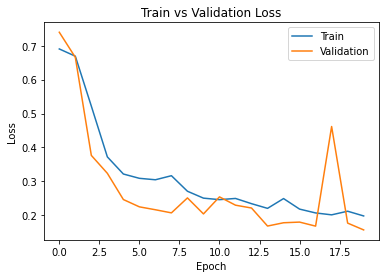

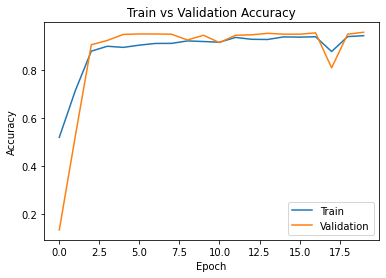

Final Training Accuracy: 0.9436246062012933
Final Validation Accuracy: 0.957847533632287


In [ ]:
# Since the training curves of the model in Part (b) were noisy, learning_rate is decreased from 2e-4 to 1e-4
model_1 = RNN(50)
train(model_1, train_iter, valid_iter, num_epochs=20, learning_rate=1e-4)

# Results:
# Final Training Accuracy: 0.9436246062012933
# Final Validation Accuracy: 0.957847533632287

In [ ]:
# In Part 2, it is stated that the way the RNN outputs are pooled can be tuned as well
# A new architecture that uses max-pool over the entire output array is proposed
class RNN_max(nn.Module):
    def __init__(self, hidden_size):
        super(RNN_max, self).__init__()
        self.name = "rnn_max"
        self.emb = torch.eye(len(text_field.vocab.itos))
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(len(text_field.vocab.itos), hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)
    
    def forward(self, x):
        x = self.emb[x]
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc(torch.max(out, dim=1)[0])
        return out

Epoch 1: Train acc: 0.5199801028021886, Train loss: 0.6864059423145495 |Validation acc: 0.13452914798206278, Validation loss: 0.7529377225372527
Epoch 2: Train acc: 0.5201459127839496, Train loss: 0.6629379542250382 |Validation acc: 0.13452914798206278, Validation loss: 0.7016291419665018
Epoch 3: Train acc: 0.8386668877466423, Train loss: 0.6250654971913288 |Validation acc: 0.7201793721973094, Validation loss: 0.646301786104838
Epoch 4: Train acc: 0.9446194660918588, Train loss: 0.5436547732666919 |Validation acc: 0.9533632286995516, Validation loss: 0.5371421931518449
Epoch 5: Train acc: 0.9295307577516166, Train loss: 0.4180502640573602 |Validation acc: 0.9650224215246637, Validation loss: 0.4045275491144922
Epoch 6: Train acc: 0.9287017078428121, Train loss: 0.31714222078260623 |Validation acc: 0.9488789237668162, Validation loss: 0.32067176575462025
Epoch 7: Train acc: 0.932349527441552, Train loss: 0.254495153262427 |Validation acc: 0.9757847533632287, Validation loss: 0.23551247

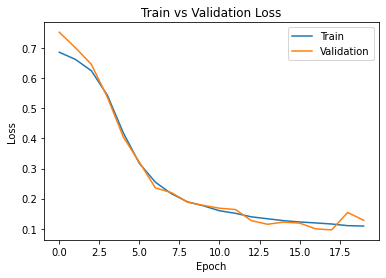

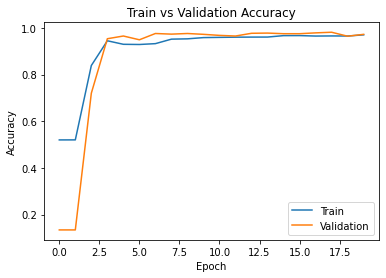

Final Training Accuracy: 0.9699883933012767
Final Validation Accuracy: 0.9721973094170404


In [ ]:
model_2 = RNN_max(50)
train(model_2, train_iter, valid_iter, num_epochs=20, learning_rate=1e-4)

# Results:
# Final Training Accuracy: 0.9699883933012767
# Final Validation Accuracy: 0.9721973094170404

In [ ]:
# Since changing the way the RNN outputs are pooled increased the training and validation accuracies,
# a new architecture that concatenates the max-pooling and average-pooling of the RNN outputs is proposed
class RNN_cat(nn.Module):
    def __init__(self, hidden_size):
        super(RNN_cat, self).__init__()
        self.name = "rnn_cat"
        self.emb = torch.eye(len(text_field.vocab.itos))
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(len(text_field.vocab.itos), hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size*2, 2)
    
    def forward(self, x):
        x = self.emb[x]
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
        return self.fc(out)

Epoch 1: Train acc: 0.5199801028021886, Train loss: 0.6829111055323952 |Validation acc: 0.13452914798206278, Validation loss: 0.7191536360316806
Epoch 2: Train acc: 0.5317526115072128, Train loss: 0.6606561965063998 |Validation acc: 0.15605381165919283, Validation loss: 0.6870254576206207
Epoch 3: Train acc: 0.8887415022384347, Train loss: 0.5713585249687496 |Validation acc: 0.8896860986547085, Validation loss: 0.5455599890814887
Epoch 4: Train acc: 0.8617144752114078, Train loss: 0.4322897091507912 |Validation acc: 0.947085201793722, Validation loss: 0.35540933658679325
Epoch 5: Train acc: 0.91543690930194, Train loss: 0.35486842691898346 |Validation acc: 0.9345291479820628, Validation loss: 0.334542453289032
Epoch 6: Train acc: 0.925717128171116, Train loss: 0.29781997635176305 |Validation acc: 0.9201793721973094, Validation loss: 0.3418952338397503
Epoch 7: Train acc: 0.925717128171116, Train loss: 0.25482927074557854 |Validation acc: 0.968609865470852, Validation loss: 0.1725908377

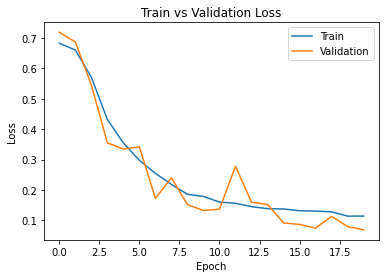

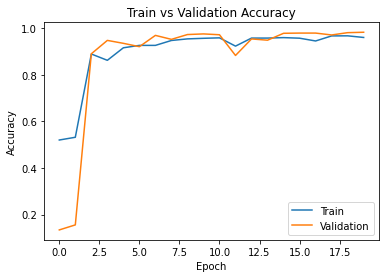

Final Training Accuracy: 0.9597081744321008
Final Validation Accuracy: 0.9820627802690582


In [ ]:
model_3 = RNN_cat(50)
train(model_3, train_iter, valid_iter, num_epochs=20, learning_rate=1e-4)

# Results:
# Final Training Accuracy: 0.9597081744321008
# Final Validation Accuracy: 0.9820627802690582

Epoch 1: Train acc: 0.6000663239927043, Train loss: 0.6759776761657313 |Validation acc: 0.29596412556053814, Validation loss: 0.6750204347901874
Epoch 2: Train acc: 0.8278892389321837, Train loss: 0.5719994723012573 |Validation acc: 0.7300448430493274, Validation loss: 0.6222045603725646
Epoch 3: Train acc: 0.915271099320179, Train loss: 0.3676341379943647 |Validation acc: 0.9596412556053812, Validation loss: 0.2304677309261428
Epoch 4: Train acc: 0.9418006964019234, Train loss: 0.2565362821480161 |Validation acc: 0.967713004484305, Validation loss: 0.1730135733054744
Epoch 5: Train acc: 0.9567235947604046, Train loss: 0.19393194319778367 |Validation acc: 0.9605381165919282, Validation loss: 0.1650052677012152
Epoch 6: Train acc: 0.9277068479522467, Train loss: 0.18250038692433584 |Validation acc: 0.8914798206278027, Validation loss: 0.310514197167423
Epoch 7: Train acc: 0.9545680649975129, Train loss: 0.17159915766433664 |Validation acc: 0.9739910313901345, Validation loss: 0.19507517

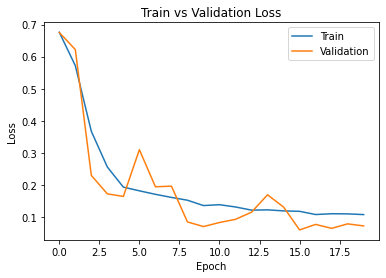

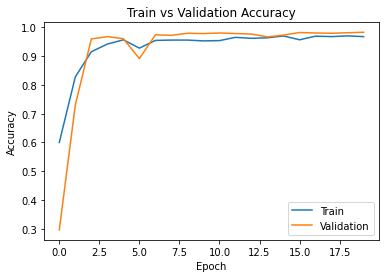

Final Training Accuracy: 0.9676670535566241
Final Validation Accuracy: 0.9829596412556054


In [ ]:
# Since model_3 performed the best so far, the number of hidden units is increased from 50 to 100 using the RNN_cat architecture

model_4 = RNN_cat(100)
train(model_4, train_iter, valid_iter, num_epochs=20, learning_rate=1e-4)

# Results:
# Final Training Accuracy: 0.9676670535566241
# Final Validation Accuracy: 0.9829596412556054

**Answer:**

`model_4` produces the best results, with a final validation accuracy of `98.3%`.

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

valid_spam_iter = torchtext.legacy.data.BucketIterator(valid_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), 
                                           sort_within_batch=True,      
                                           repeat=False)

valid_nospam_iter = torchtext.legacy.data.BucketIterator(valid_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), 
                                           sort_within_batch=True,      
                                           repeat=False)    

valid_false_positive = 1 - get_accuracy(model_4, valid_nospam_iter)
valid_false_negative = 1 - get_accuracy(model_4, valid_spam_iter)

print("The false positive rate is", valid_false_positive*100, "%")
print("The false negative rate is", valid_false_negative*100, "%")

The false positive rate is 1.4507772020725396 %
The false negative rate is 4.0000000000000036 %


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

**Answer:**

If the spam detection algorithm was deployed on my phone, a high false positive rate would mean that normal texts I receive can potentially be marked as spam as well. This could lead to the negligence or deletion of important texts that I might receive. On the other hand, a high false negative rate would mean that the algorithm is often labeling spam texts as normal texts, which means that it is not performing very well at reducing the amount of spam texts I might receive. 

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [ ]:
test_iter = torchtext.legacy.data.BucketIterator(test,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,    
                                           repeat=False)     

test_acc = get_accuracy(model_4, test_iter)       
print("The final test accuracy of my model is", test_acc*100, "%")      

The final test accuracy of my model is 97.3967684021544 %


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:

test_spam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)

test_nospam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)

test_spam_iter = torchtext.legacy.data.BucketIterator(test_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), 
                                           sort_within_batch=True,      
                                           repeat=False)

test_nospam_iter = torchtext.legacy.data.BucketIterator(test_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), 
                                           sort_within_batch=True,      
                                           repeat=False)    

test_false_positive = 1 - get_accuracy(model_4, test_nospam_iter)
test_false_negative = 1 - get_accuracy(model_4, test_spam_iter)

print("The false positive rate is", test_false_positive*100, "%")
print("The false negative rate is", test_false_negative*100, "%")

The false positive rate is 1.9689119170984481 %
The false negative rate is 7.38255033557047 %


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [ ]:
msg = "machine learning is sooo cool!"
msg_stoi = []
for i in range(len(msg)):
    msg_stoi.append(text_field.vocab.stoi[msg[i]])

test_msg = torch.LongTensor(msg_stoi).unsqueeze(dim=0)
pred = model_4(test_msg)
prob = F.softmax(pred, dim=1)
print("The probability that \"machine learning is sooo cool!\" is spam is", float(prob[0][1]*100), "%")

The probability that "machine learning is sooo cool!" is spam is 5.805425643920898 %


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

**Answer:**

In my opinion, it is not difficult to achieve high accuracies for spam detection using a recurrent neural network model. However, even with a high overall accuracy, the impact of false positives and false negatives can still be significant. So, it is important to reduce these errors as much as possible, which is the difficult part. 

A simple baseline model could be built through targeting keywords in common spam messages and labeling any messages containing these keywords as spams. This can be an easy to build and inexpensive model to compare the recurrent neural network against.